In [1]:
import resource
import sys
import gc
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.data as ds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functools import partial
import sklearn.cluster as clustering
import sklearn.decomposition as decomposition

print(tf.version.VERSION)
!nvidia-smi -L

2021-08-16 22:43:08.014780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-16 22:43:08.014798: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.5.0
/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# uncomment for debugging layers
# tf.config.run_functions_eagerly(True) 


@tf.function
def image_float_to_int(image): 
    return tf.image.convert_image_dtype(image, tf.uint8)


@tf.function
def load_image(file_path, img_size=[306, 306]):
    raw = tf.io.read_file(file_path)
    return tf.image.decode_jpeg(raw, channels=3)


@tf.function
def random_crop(image, size=128):
    '''
    crop a random box out of the image
    :param image: image tensor to be modified
    :param size: int. The pixel size of the cropped box
    '''
    s = tf.shape(image)
    w = s[0]
    h = s[1]
    c = s[2]
    dh = size
    dw = size
    dx = tf.random.uniform([1], minval=0, maxval=w-dw, dtype=tf.dtypes.int32, seed=None, name=None)[0]
    dy = tf.random.uniform([1], minval=0, maxval=h-dh, dtype=tf.dtypes.int32, seed=None, name=None)[0]
    offset_height = dy
    target_height = dh
    offset_width = dx
    target_width = dw
    image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)
    return image


@tf.function
def box_delete(image, size=32, l=0.9):
    '''
    :param image: image tensor to be modified
    :param strength: int. The pixel size of the deleted box
    '''
    s = tf.shape(image)
    w = s[0]
    h = s[1]
    c = s[2]
    # compute size and position of mask
    dh = size
    dw = size
    dx = tf.random.uniform([1], minval=0, maxval=w-dw, dtype=tf.dtypes.int32, seed=None, name=None)[0]
    dy = tf.random.uniform([1], minval=0, maxval=h-dh, dtype=tf.dtypes.int32, seed=None, name=None)[0]
    # prepare indices
    xs = tf.range(start=dx, limit=dx+dw)
    ys = tf.range(start=dy, limit=dy+dh)
    X, Y = tf.meshgrid(ys, xs)
    X = tf.reshape(X, [-1, 1])
    Y = tf.reshape(Y, [-1, 1])
    mask_indices = tf.concat([Y, X], axis=-1)
    mask_indices = tf.reshape(mask_indices, [-1, 2])
    # prepare image patch
    updates_hard = tf.random.uniform([dw*dh, c], minval=0, maxval=1, dtype=tf.dtypes.float32) # hard noise
    updates_soft = tf.random.uniform([dw*dh, c], minval=0, maxval=0.1, dtype=tf.dtypes.float32) # soft noise
    updates_black = tf.zeros([dw*dh, c], dtype=tf.dtypes.float32) # black (zeros)
    # overwrite image with patch
    modified_image = tf.tensor_scatter_nd_update(image, mask_indices, updates_black, name=None) # replace with noise
    lam = tf.constant(l, dtype=tf.dtypes.float32)
    one_minus_lam = tf.constant(1-l, dtype=tf.dtypes.float32)
    updates_weights = tf.ones([dw*dh, c], dtype=tf.dtypes.float32) * one_minus_lam
    weights = tf.tensor_scatter_nd_update(tf.ones_like(image, dtype=tf.dtypes.float32) * lam, mask_indices, updates_weights, name=None)
    weights = tf.reshape(weights, [-1,])
#     modified_image = tf.tensor_scatter_nd_add(image, mask_indices, updates_black, name=None) # add noise
    return modified_image, image, weights

@tf.function
def add_noise(image, strength=0.1):
    '''
    :param image: image tensor to be modified
    :param strength: float, [0,1]. The amount of noise to add
    '''
    s = tf.shape(image)
    w = s[0]
    h = s[1]
    c = s[2]
    # prepare noise
    noise = tf.random.uniform([w, h, c], minval=0, maxval=strength, dtype=tf.dtypes.float32) # soft noise
    # add noise
    modified_image = image + noise
    weights = tf.ones_like(image, dtype=tf.dtypes.float32)
    weights = tf.reshape(weights, [-1,])
    return modified_image, image, weights

def flatten_labels(modified_image, image, weights):
    flattened = tf.reshape(image, [-1,1])
    return modified_image, flattened, weights

## visualize the dataset
def visualize_dst(dst):
    print_images = dst.take(9)
    plt.figure(figsize=(10, 10))
    for i, images, weights in enumerate(print_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images.numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")
    return dst


def visualize_training(dst):
    dst = dst.take(3)
    plt.figure(figsize=(6, 10))
    i = 0
    for image, gt, weights in dst:
        image = tf.image.convert_image_dtype(image, tf.uint8)
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        i+=1
        plt.axis("off")
        gt = tf.image.convert_image_dtype(gt, tf.uint8)
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(gt.numpy().astype("uint8"))
        i+=1
        plt.axis("off")
        #plt.title(class_names[labels[i]])
    return dst

Now that we have an input pipeline and we can see and verify our data, lets create a model.
Given image A and its distorted version D(A), compute a recovered version R(D(A)) which is as close as possible to the original A:
argmin_W{|A-R_W(D(A))|^2}

We will go with a unet model which will encode the features to each pixel. We will then train the DNN on the above task.
Thus for an input x the model will output:
f(x)=En(x) - the pixel wise features
R(x)=De(x) - the recovered picture

In [ ]:
# inspect graphs to find if memory leak is here
tf.executing_eagerly()


In [ ]:
class ConvBlock(keras.layers.Layer):
    '''
    convolution block for unet with optional max pooling
    '''
    def __init__(self, filters, downsample=True, bname='', **kwargs):
        self.filters = filters
        self.bname = bname
        self.downsample = downsample
        super(ConvBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_conv_1")
        self.conv2 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_conv_2")
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'bname': self.bname,
            'downsample': self.downsample
        })
        return config
    
    
    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = keras.layers.ReLU(name=self.bname+"_relu_1")(x)
        # stride 2, padding 1, k=3, o=i/2
#         x = keras.layers.ZeroPadding2D(padding=(1, 1), data_format='channels_last', name=self.bname+"_zeroPad")(x) 
        x = self.conv2(x)
        x = keras.layers.ReLU(name=self.bname+"_relu_2")(x)
        p = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', 
                                      name=self.bname+"_maxpool")(x)
        return x, p


class DeConvBlock(keras.layers.Layer):
    '''
    convolution block for unet with optional max pooling
    '''
    def __init__(self, filters, bname='', **kwargs):
        self.filters = filters
        self.bname = bname
        super(DeConvBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2DTranspose(filters=self.filters, kernel_size=(3,3), strides=2,
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_deconv")
        self.conv2 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=1,
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_conv")
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'bname': self.bname
        })
        return config
    
    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = keras.layers.ReLU(name=self.bname+"_relu_1")(x)
        x = self.conv2(x)
        x = keras.layers.ReLU(name=self.bname+"_relu_2")(x)
        return x

class PaddedBase(keras.layers.Layer):
    '''
    base class for layers involving padding one input to match the other
    '''
    def build(self, input_shape):
        self.shape1 = input_shape[0]
        self.shape2 = input_shape[1]
        dh = self.shape1[1] - self.shape2[1]
        dw = self.shape1[2] - self.shape2[2]
        self.bigger_shape = self.shape1[:3]
        self.smaller_shape = self.shape2[:3]
        self.c1 = self.shape1[3]
        self.c2 = self.shape2[3]
        self.pred = tf.logical_or(tf.math.less(dw, 0), tf.math.less(dh, 0))
        if self.pred:
            dh = - dh
            dw = - dw
            self.bigger_shape = self.shape2[:3]
            self.smaller_shape = self.shape1[:3]
        hmod = tf.math.floormod(dh, 2)
        hdiv = tf.cast(tf.math.divide(dh - hmod, 2), tf.int32)
        wmod = tf.math.floormod(dw, 2)
        wdiv = tf.cast(tf.math.divide(dw - wmod, 2), tf.int32)
        dhup = hdiv
        dhdown = hdiv + hmod
        dwleft = wdiv
        dwright = wdiv + wmod
        padB = tf.constant([0, 0])
        padh = tf.stack([dhup, dhdown], axis=-1)
        padw = tf.stack([dwleft, dwright], axis=-1)
        padC = tf.constant([0, 0])
        self.paddings = tf.stack([padB, padh, padw, padC], axis=0)

class PadToSize(PaddedBase):
    '''
    padding the smaller tensor so the shapes match and return the first
    '''
    @tf.function
    def call(self, inputs):
        tensor_1, tensor_2 = inputs
        tensor_3 =  tf.pad(tensor_1, paddings=self.paddings , mode='CONSTANT', constant_values=0)
        return tensor_3
        
class PaddedConcat(PaddedBase):
    '''
    concats two tensors, padding the smaller tensor so the shapes match
    ''' 
    @tf.function
    def call(self, inputs):
        tensor_1, tensor_2 = inputs
        tensor_3 =  tf.pad(tensor_1, paddings=self.paddings , mode='CONSTANT', constant_values=0)
        out = tf.concat([tensor_3, tensor_2], axis=-1)
        return out

class PaddedAdd(PaddedBase):
    '''
    concats two tensors, padding the smaller tensor so the shapes match
    '''
    @tf.function
    def call(self, inputs):
        tensor_1, tensor_2 = inputs
        tensor_3 =  tf.pad(tensor_1, paddings=self.paddings , mode='CONSTANT', constant_values=0)
        out = tf.math.add(tensor_3, tensor_2)
        return out
    
class CropToShape(keras.layers.Layer):
    '''
    crop input to specified shape
    '''
    def build(self, input_shape):
        shape1 = input_shape[0]
        shape2 = input_shape[1]
        self.h = shape2[1]
        self.w = shape2[2]
    
    @tf.function
    def call(self, inputs):
        return tf.slice(inputs[0], [0, 0, 0, 0], [-1, self.h, self.w, -1])

    
def bridge(x, bridge_features, num=0):
    if len(bridge_features) > 0:
        name = "bridge_layer_"+str(num)
        x = keras.layers.Conv2D(filters=bridge_features[0], kernel_size=(3,3), strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=name+"_conv")(x)
        x = keras.layers.ReLU(name=name+"_relu")(x)
        return bridge(x, bridge_features[1:], num+1)
    else:
        return x
        
    
def Unet(x, bridge_features, encoder_filters_list, decoder_filters_list, skip_connections, level=0):
    tf.debugging.assert_shapes([(encoder_filters_list,('N')),(decoder_filters_list,('N'))],
                               message="encoder and decoder have different length!")
    #encoder
    bname = "encoder_layer_"+str(level)
    xout, p = ConvBlock(encoder_filters_list[0], bname=bname)(x)
    if len(encoder_filters_list) > 1:
        x = Unet(p, bridge_features, encoder_filters_list[1:], 
                 decoder_filters_list[:-1], skip_connections[:-1], level=level+1)
    else:
        x = bridge(p, bridge_features, num=0)
    #decoder
    bname = "decoder_features_"+str(level)
    x = DeConvBlock(decoder_filters_list[-1], bname=bname)(x)
    if skip_connections[-1]==1:
        # skip connection
        print("x:", x)
        print("xout:", xout)
        x = PaddedConcat(name=bname+"_concat")([x, xout])
#         x = PaddedAdd(name=bname+"_add")([x, xout])
    else:
        # no skip connection here so just padd as necessary
        x = PadToSize()([x, xout])
    return x
    

def AutoEncoder(x, bridge_features, encoder_filters_list, decoder_filters_list, level=0):
    tf.debugging.assert_shapes([(encoder_filters_list,('N')),(decoder_filters_list,('N'))],
                               message="encoder and decoder have different length!")
    #encoder
    bname = "encoder_layer_"+str(level)
    xout, p = ConvBlock(encoder_filters_list[0], bname=bname)(x)
    if len(encoder_filters_list) > 1:
        x = AutoEncoder(p, bridge_features, encoder_filters_list[1:], decoder_filters_list[:-1], level=level+1)
    else:
        x = bridge(p, bridge_features, num=0)
    #decoder
    bname = "decoder_features_"+str(level)
    x = DeConvBlock(decoder_filters_list[-1], bname=bname)(x)  
    x = PadToSize()([x, xout])
    return x
        

def get_completion_model(bridge_features, encoder_filters_list, decoder_filters_list, skip_connections,
                         head_filters_list):
    image = keras.layers.Input(shape=[128,128, 3], dtype='float32', name="input_org")
    features = Unet(image, bridge_features, encoder_filters_list, decoder_filters_list, skip_connections)
#     features = AutoEncoder(image, bridge_features, encoder_filters_list, decoder_filters_list)
    kernel_size = (1,1) #(3,3)
    for i, f in enumerate(head_filters_list):
        features_in = features
        features = keras.layers.Conv2D(filters=f, kernel_size=kernel_size, strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros")(features)
        features = keras.layers.ReLU(name="head_conv_"+str(i)+"_conv_out")(features)
    recovered_image = features
    flattened_recovered_image = tf.keras.layers.Reshape([-1,1])(recovered_image)
    return keras.Model(inputs=image, outputs=flattened_recovered_image)

def get_simple_model():
    image = keras.layers.Input(shape=[128,128, 3], dtype='float32', name="input_org")
    features = keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(image)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid", data_format='channels_last')
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid", data_format='channels_last')
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid", data_format='channels_last')
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.UpSampling2D(size=(2, 2), data_format='channels_last', interpolation="nearest")
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.UpSampling2D(size=(2, 2), data_format='channels_last', interpolation="nearest")
    features = keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    tf.keras.layers.UpSampling2D(size=(2, 2), data_format='channels_last', interpolation="nearest")
    features = keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    features = keras.layers.Conv2D(filters=3, kernel_size=(3,3), strides=(1, 1), padding="same", data_format='channels_last')(features)
    features = tf.keras.layers.Reshape([-1,1])(features)
    return keras.Model(inputs=image, outputs=features)

class PixelWiseHuberVisualize(keras.losses.Loss):
    def call(self, img_true, img_pred):
        #img_pred = tf.reshape(tf.convert_to_tensor_v2(img_pred), [-1, 1])
#         img_pred = tf.reshape(img_pred, [-1, 1])
#         img_true = tf.reshape(tf.cast(img_true, img_pred.dtype), [-1, 1])
        # image values are in [0,1] so put delta in the middle
        h = tf.math.squared_difference(img_pred, img_true)
#         h = tf.keras.losses.Huber(delta=0.5, reduction=keras.losses.Reduction.NONE)
#         return h(img_pred, img_true)
        return h


class PixelWiseHuber(keras.losses.Loss):
    @tf.function
    def call(self, img_true, img_pred):
        #img_pred = tf.reshape(tf.convert_to_tensor_v2(img_pred), [-1, 1])
#         img_pred = tf.reshape(img_pred, [-1, 1])
#         img_true = tf.reshape(tf.cast(img_true, img_pred.dtype), [-1, 1])
        # image values are in [0,1] so put delta in the middle
        shape1 = tf.shape(img_pred)
        shape2 = tf.shape(img_true)
#         tf.print("pred shape=", shape1, "original shape=", shape2)
        return tf.keras.losses.Huber(delta=0.5)(img_pred, img_true)

Test the loss function to see that it gives correct values. Test by adding noise to an image and plotting the loss as a function of SNR:

In [ ]:
# inspect graphs to find if memory leak is here

In [ ]:
@tf.function
def add_gaussian_noise(image, invSNR):
    A = tf.norm(image)
    std = invSNR * A
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=std)
    return tf.math.add(image, noise)


def visualize_loss(dst):
    original = dst.take(1)

    plt.figure(figsize=(10, 10))
    for original in original:
        aug, org, w = original
        #     loss_image = original.map(tf.math.squared_difference)
        org = tf.reshape(org, tf.shape(aug))
        loss_image = keras.losses.huber(aug, org)
        loss_image = tf.image.convert_image_dtype(loss_image, tf.uint8)
        aug = tf.image.convert_image_dtype(aug, tf.uint8)
        org = tf.image.convert_image_dtype(org, tf.uint8)
        ax = plt.subplot(1,3,1)
        plt.imshow(loss_image.numpy().astype("uint8"))
        ax = plt.subplot(1,3,2)
        plt.imshow(aug.numpy().astype("uint8"))
        ax = plt.subplot(1,3,3)
        plt.imshow(org.numpy().astype("uint8"))
    return dst

class GCCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

class MemoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, logfile):
        super(MemoryCallback, self).__init__()
        self.logfile = logfile
        if os.path.exists(logfile):
            os.remove(logfile)
    def on_train_batch_begin(self, batch, logs={}):
        if batch % 100 == 0:
            print(' ',resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
            with open(self.logfile,'a') as f:
                f.writelines([f'{batch} {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss}'])

Now lets train. params:
- unet_num_features
- unet_filters_list
- head_filters_list
Note that the head capabilities strongly depend on how many filters are applied: The maximum "interpolation length" is ~ 3*num_filters

In [ ]:
station = "home"
# station = "aws"
train=False
evaluate=False

if station=="aws":
    home = os.getenv("HOME")
elif station=="home":
    home = "/home/lior/PycharmProjects/facesTasks"
    
print("current working directory:", home)

copies_per_image = 1
images_per_batch = 3
dataset = tf.data.Dataset.list_files(f'{home}/images/*.jpg')
# train/test split
image_count = tf.cast(dataset.cardinality(), tf.float32)
train_perc = tf.constant(0.8)
train_dataset = dataset.take(tf.cast(tf.math.round(image_count * train_perc), tf.int64))
val_dataset = dataset.skip(tf.cast(tf.math.round(image_count * train_perc), tf.int64))
train_dataset = train_dataset.shuffle(buffer_size=1000)
val_dataset = val_dataset.shuffle(buffer_size=1000)
# train several times on each image (augmentations will be different)
# train_dataset = train_dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x)#.repeat(copies_per_image)
#                                          ,cycle_length=4, block_length=copies_per_image)
# val_dataset = val_dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x)#.repeat(copies_per_image)
#                                      ,cycle_length=4, block_length=copies_per_image)
# read the images
train_dataset = train_dataset.map(load_image, num_parallel_calls=3).cache()
train_dataset = train_dataset.map(partial(tf.image.convert_image_dtype, dtype=tf.float32), num_parallel_calls=3)
val_dataset = val_dataset.map(load_image, num_parallel_calls=3).cache()
val_dataset = val_dataset.map(partial(tf.image.convert_image_dtype, dtype=tf.float32), num_parallel_calls=3)

# prepare augmented images. dataset of (augmented image, image), block_length augmentions for each
train_dataset = train_dataset.map(partial(random_crop, size=128), num_parallel_calls=3)
train_dataset = train_dataset.map(partial(box_delete, size=32, l=0.06), num_parallel_calls=3)

val_dataset = val_dataset.map(partial(random_crop, size=128), num_parallel_calls=3)
val_dataset = val_dataset.map(partial(box_delete, size=32, l=0.06), num_parallel_calls=3)

# visualize
train_dataset.apply(visualize_training)

# save current state of pipeline for segmentation ahead
train_dataset_seg = train_dataset
val_dataset_seg = val_dataset


# flatten the original image ("label") so we can use sample weights
train_dataset = train_dataset.map(partial(flatten_labels), num_parallel_calls=3)
val_dataset = val_dataset.map(partial(flatten_labels), num_parallel_calls=3)
# shuffle and batch
train_dataset = train_dataset.batch(images_per_batch * copies_per_image, drop_remainder=True)
val_dataset   = val_dataset.batch(images_per_batch * copies_per_image, drop_remainder=True)
# prefetch
train_dataset = train_dataset.prefetch(10)
val_dataset = val_dataset.prefetch(4)

print("done dataset preparations")
print(train_dataset)

# AE V1
#bridge_features = [16]
# encoder_filters_list = [ 64, 64, 128, 128, 256, 256]
# decoder_filters_list = [256, 256, 128, 128, 64, 64]
# head_filters_list = [32, 32, 16, 3]
bridge_features = [16, 16, 16, 16]
encoder_filters_list = [128, 64, 32, 32, 32]
skip_connections =     [1 ,  1 , 1,  0,  0]
decoder_filters_list = [32, 32, 32,  64, 128]
head_filters_list = [3]

cp_file = f'{home}/session/model_cp.h5'
if os.path.exists(cp_file):
    print("found checkpoint, loading")
    model = tf.keras.models.load_model(cp_file, 
                               custom_objects={'ConvBlock': ConvBlock, 'DeConvBlock': DeConvBlock, 
                                               'PadToSize': PadToSize, 'PixelWiseHuber': PixelWiseHuber,
                                               'PaddedConcat': PaddedConcat, 'PaddedAdd': PaddedAdd})
    # test model
    if evaluate:
        print("evaluating model on val_dataset:")
        results = model.evaluate(val_dataset)
        print(dict(zip(model.metrics_names, results)))

    
else:
    print("checkpoint not found, compiling fresh model")
    model = get_completion_model(bridge_features, encoder_filters_list, decoder_filters_list, skip_connections,
                                 head_filters_list)
#     model = get_simple_model() # for debugging memory leak and comparison with our model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.001) # default lr, use reduction strategy below
    model.compile(optimizer=opt, loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

# garbage_collect_cb = GCCallback()
# lr_strategy_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.1, patience=3, verbose=1,
#                                                                 mode="min", min_delta=0.001, cooldown=0, min_lr=0.0000001)

model.summary()

if not station=="home" and train==True: # don't train on home pc
    history = model.fit(x=train_dataset, #steps_per_epoch=2000, 
                    epochs=100, validation_data=val_dataset, validation_steps=5, validation_freq=1,
                        workers=3
                        , callbacks=[tf.keras.callbacks.ModelCheckpoint(cp_file, verbose=1)]
                   )

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.savefig(f'{home}/train_history.png')

visualize results

In [ ]:
vis_val = val_dataset.unbatch().shuffle(buffer_size=100).shard(num_shards=100, index=0)

def visualize_results(dst):
    dst = dst.take(6)
    plt.figure(figsize=(10, 20))
    i = 0
    for image, gt, weights, result in dst:
        image = tf.image.convert_image_dtype(image, tf.uint8)
        ax = plt.subplot(6, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        i+=1
        plt.axis("off")
        gt = tf.image.convert_image_dtype(gt, tf.uint8)
        ax = plt.subplot(6, 3, i + 1)
        plt.imshow(gt.numpy().astype("uint8"))
        i+=1
        plt.axis("off")
        result = tf.image.convert_image_dtype(result, tf.uint8)
        ax = plt.subplot(6, 3, i + 1)
        plt.imshow(result.numpy().astype("uint8"))
        i+=1
        plt.axis("off")
    return dst

def do_model(image, gt, w, model):
    shape = tf.shape(image)
    image = tf.expand_dims(image, axis=0)
    result = model(image)
    image = tf.reshape(image, shape)
    result = tf.reshape(result, shape)
    gt = tf.reshape(gt, shape)
    return image, gt, w, result
do_my_model = lambda x, y, z: do_model(x, y, z, model)
results_val = vis_val.map(do_my_model)
print(results_val)
results_val.apply(visualize_results)

We can use this model as a segmentation model by removing the head and using a clustering algorithm.

In [ ]:
# Copyright 2019 Google LLC.
# SPDX-License-Identifier: Apache-2.0

# Author: Anton Mikhailov

turbo_colormap_data = np.array([[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]])

# The look-up table contains 256 entries. Each entry is a floating point sRGB triplet.
# To use it with matplotlib, pass cmap=ListedColormap(turbo_colormap_data) as an arg to imshow() 
# (don't forget "from matplotlib.colors import ListedColormap").
# If you have a typical 8-bit greyscale image, you can use the 8-bit value to index into this LUT directly.
# The floating point color values can be converted to 8-bit sRGB via multiplying by 255 and casting/flooring to 
# an integer. Saturation should not be required for IEEE-754 compliant arithmetic.
# If you have a floating point value in the range [0,1], you can use interpolate() to linearly interpolate 
# between the entries.
# If you have 16-bit or 32-bit integer values, convert them to floating point values on the [0,1] range 
# and then use interpolate(). Doing the interpolation in floating point will reduce banding.
# If some of your values may lie outside the [0,1] range, use interpolate_or_clip() to highlight them.

def interpolate(colormap, x):
    x = np.minimum(0.0, np.minimum(1.0, x))
    a = x*255.0
    a = a.astype(int)
    b = np.minimum(255, a + 1)
    b = np.floor(b).astype(int)
    f = x*255.0 - a
    f = f.astype(float)
    return np.array([colormap[a][0] + (colormap[b][0] - colormap[a][0]) * f,
            colormap[a][1] + (colormap[b][1] - colormap[a][1]) * f,
            colormap[a][2] + (colormap[b][2] - colormap[a][2]) * f])

def interpolate_or_clip(colormap, x):
    if   x < 0.0: return [0.0, 0.0, 0.0]
    elif x > 1.0: return [1.0, 1.0, 1.0]
    else: return interpolate(colormap, x)

We cluster the pixel features using yet another fully connected auto encoder with shared weights (1x1 convs). The loss function is L=|p-D(E(p))|^2. The code is analogous to a ICA (independent component analysis). Minimizing the loss function is equivalent to maximizing the mutual information between the code and the original pixel, which is just the ICA analysis. 

f:features

c:code

I(f;c)=H(f) - H(f|c)

f = D(c) + n

P(f|c) = P(n) = P_D(p-D(c)) = P(L)

L = |p-D(c)|^2

argmax_D I = argmin_D L

The autoencoder can be linear (ICA) or nonlinear (deep).
The code can be visualised using colormaps

In [ ]:
def do_seg_model(images, model):
    features = model(images)
    return features

@tf.function
def imagesToPixels(image):
    shape = tf.shape(image)
    return tf.reshape(image, [shape[0], shape[1] * shape[2], shape[3]])


def get_cmap(colormap_data):
        def cmap(x):
            return interpolate(colormap_data, x)
        return cmap
        
def cmap_on_image(cmap_func):
    return np.vectorize(cmap_func, signature="()->(3)")


def visualize_code(dst):
    dst = dst.take(6)
    plt.figure(figsize=(10, 10))
    i = 0
    for image in dst:
        image = tf.image.convert_image_dtype(image, tf.uint8)
        ax = plt.subplot(6, 1, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        i+=1
        plt.axis("off")
    return dst

def split(image):
    return tf.reshape(image, [-1,1,128])


In [ ]:
layer_name = "pad_to_size_1"
seg_model = keras.Model(inputs=model.input,
                        outputs=model.get_layer(layer_name).output)
# seg_model.trainable = False # freezing not needed since the models are not actually connected

features_img = tf.keras.Input(shape=[128, 128, 128], dtype='float32', name="input_org")
code = keras.layers.Conv2D(filters=256, kernel_size=(1,1), data_format='channels_last')(features_img)
code = keras.layers.ReLU()(code)
code = keras.layers.Conv2D(filters=64, kernel_size=(1,1), data_format='channels_last')(features_img)
code = keras.layers.ReLU()(code)
code = keras.layers.Conv2D(filters=16, kernel_size=(1,1), data_format='channels_last')(code)
code = keras.layers.ReLU(name="encoder_out")(code)
decoder = keras.layers.Conv2D(filters=64, kernel_size=(1,1), data_format='channels_last')(code)
code = keras.layers.ReLU()(decoder)
decoder = keras.layers.Conv2D(filters=256, kernel_size=(1,1), data_format='channels_last')(decoder)
code = keras.layers.ReLU()(decoder)
decoder = keras.layers.Conv2D(filters=128, kernel_size=(1,1), 
                              data_format='channels_last', name="decoder_out")(decoder)

autoencoder_model = keras.Model(inputs=features_img, outputs=decoder)


get_gt = lambda image, gt, w: gt

print("building clustering training pipline")
extract_seg_features = lambda images: do_seg_model(images, seg_model)

# training data pipeline
# shuffle and batch
images_per_batch = 10
train_dataset_seg_batched = train_dataset_seg.batch(images_per_batch, drop_remainder=True)
val_dataset_seg_batched   = val_dataset_seg.batch(images_per_batch, drop_remainder=True)

train_dataset_seg_pixels = train_dataset_seg_batched.map(get_gt, num_parallel_calls=3)
val_dataset_seg_batched  = val_dataset_seg_batched.map(get_gt, num_parallel_calls=3)
train_dataset_seg_pixels = train_dataset_seg_pixels.map(extract_seg_features, num_parallel_calls=3)
val_dataset_seg_batched  = val_dataset_seg_batched.map(extract_seg_features, num_parallel_calls=3)

print("pca_train_dataset:",train_dataset_seg_pixels)
# process 1000 pixels per batch instead of ~128 (memory effcient)
autoencoder_train_dataset = train_dataset_seg_pixels.map(lambda x: (x,x)).prefetch(10)
print("train_dataset_seg_pixels:",train_dataset_seg_pixels)

In [ ]:
ae_cp_file = f'{home}/session/autoencoder_deep_cp.h5'
training = False
if os.path.exists(ae_cp_file):
    print("found checkpoint, loading")
    load_ae = True
else:
    load_ae = False
if load_ae and not training:
    autoencoder_model = tf.keras.models.load_model(ae_cp_file)
    
if training:
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.001) # default lr, use reduction strategy below
    autoencoder_model.compile(optimizer=opt, loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
    if load_ae:
        print("loading model weights for training")
        autoencoder_model.load_weights(filepath=ae_cp_file)
    autoencoder_model.fit(autoencoder_train_dataset, 
                      epochs=3, validation_data=val_dataset, validation_steps=5, validation_freq=1,
                        workers=3
                        , callbacks=[tf.keras.callbacks.ModelCheckpoint(ae_cp_file, verbose=1, save_freq=500)])

In [ ]:
layer_name = "encoder_out"
encoder_model =  keras.Model(inputs=autoencoder_model.input,
                        outputs=autoencoder_model.get_layer(layer_name).output)

val_dataset_seg_code = val_dataset_seg_batched.map(encoder_model).unbatch()
val_dataset_seg_code = val_dataset_seg_code.map(image_float_to_int)

def visualize_seg(dst):
    dst = dst.take(3)
    for image in dst:
        plt.figure(figsize=(30, 30))
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            arr = image.numpy()
            plt.imshow(arr[:,:,i])
            i+=1
            plt.axis("off")
        plt.show()
    return dst

In [ ]:
val_dataset_seg_code.apply(visualize_seg)

We see that for the most part the code corresponds to features which are spread across the whole picture. We don't see features that correspond to particular body parts like eyes etc. This makes sense since the results were quite blurry and seem to be somewhat of a naive extrapolation of the surroundings.

This result is not due to the encoder since we can decode the pixels from it very precisely. In fact it may be that the features (and the code) correspond to the rgb values due to the UNET's skip connections.

# Attempt #2

We will use a GAN architecture similar to infoGAN: https://arxiv.org/pdf/1606.03657.pdf

However there are several changes relative to this work:

1. As we want a segmentation map, we need to generate a code per pixel. Thus the architecture will be similar to what we tried above with two changes. We will not use skip connections between the encoder and decoder so we can clearly identify the code. Also we will use "same" padding and strided convolutions to mimic the downsampling while generating a code for each pixel.

2. As was shown just above, maximizing the mutual information is the same as minimizing the distance between the decoded signal and the original signal. In infoGAN the mutual information I(c;G(c,z)) is maximized. Therefore we will minimize the distance L=|c-E(G(c,z))|^2. That is, we use the encoder part on the generated image to generate a code as similar as possible to the original one that was sampled while training the GAN. This part can be trained seperately from the generator (i.e. decoder) and the discriminator. Therefore the segmentor is actually the encoder which we will get "for free" with this method.

3. I will use the WGAN method of https://arxiv.org/pdf/1701.07875.pdf. Additionaly we use the gradient penalty of https://arxiv.org/pdf/1704.00028.pdf

To reduce training time the discriminator can actually be trained as an alternate "head" of the encoder. This is actually what was done in the infoGAN paper.

In drawing samples from the latent space, we use a gaussian of unit variance. Since each pixel has N components in the code, we need each component to be a gaussian of variance 1/sqrt(N) (this way the total variance is 1).

In [3]:
class EncoderBlock(keras.layers.Layer):
    '''
    convolution block for unet with optional max pooling
    '''
    def __init__(self, filters, bname='', **kwargs):
        self.filters = filters
        self.bname = bname
        super(EncoderBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_conv_1")
        self.conv2 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=(1, 1),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_conv_2")
        self.conv3 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=(2, 2),
                            padding="same", data_format='channels_last', kernel_initializer="glorot_uniform",
                            bias_initializer="zeros", name=bname+"_conv_3")
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'bname': self.bname,
            'downsample': self.downsample
        })
        return config
    
    
    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = keras.layers.LeakyReLU(alpha=0.1, name=self.bname+"_relu_1")(x)
        x = self.conv2(x)
        x = keras.layers.LeakyReLU(alpha=0.1, name=self.bname+"_relu_2")(x)
        
        x = tf.concat([x, inputs], axis=-1) # skip connection
        
        x = self.conv3(x)
        x = keras.layers.LeakyReLU(alpha=0.1, name=self.bname+"_relu_3")(x)
        return x


class GeneratorBlock(keras.layers.Layer):
    '''
    convolution block for unet with optional max pooling
    '''
    def __init__(self, filters, bname='', **kwargs):
        self.filters = filters
        self.bname = bname
        super(GeneratorBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2DTranspose(filters=self.filters, kernel_size=(3,3), strides=2,
                            padding="same", data_format='channels_last', name=self.bname+"_deconv")
        self.conv2 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=1,
                            padding="same", data_format='channels_last', name=self.bname+"_conv_1")
        self.conv3 = keras.layers.Conv2D(filters=self.filters, kernel_size=(3,3), strides=1,
                            padding="same", data_format='channels_last', name=self.bname+"_conv_2")
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'bname': self.bname
        })
        return config
        
    
    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x1 = keras.layers.ReLU(name=self.bname+"_relu_1")(x)
        x2 = self.conv2(x1)
        x2 = keras.layers.ReLU(name=self.bname+"_relu_2")(x2)
        x3 = self.conv3(x2)
        x3 = keras.layers.ReLU(name=self.bname+"_relu_3")(x3)
        x4 = tf.math.add(x, x3) # skip connection
        
        return x4
    

def Encoder(code_features, pixel_features, decoder_filters_list):
    x = tf.keras.Input(shape=[128,128, 3], dtype='float32', name="pixels")
    y = x
    bname = "encoder_coded_pixels"
    y = tf.keras.layers.Conv2D(filters=pixel_features, kernel_size=(3, 3), strides=(1, 1), 
                               padding="same", data_format='channels_last', name="encoder_coded_pixels")(y)
    features = decoder_filters_list
    features[0] = code_features
    for i, f in enumerate(reversed(decoder_filters_list)):
        bname = "encoder_layer_"+str(i)
        y = EncoderBlock(f, bname=bname)(y)
    
    code_shape = y.shape
    return keras.Model(inputs=x, outputs=y), code_shape

def EncoderHead(code_shape):
    x = tf.keras.Input(shape=[code_shape[1], code_shape[2], code_shape[3]], 
                       dtype='float32', name="EncoderHead_convs_in")
    y = keras.layers.Flatten()(x)
    bname = "EncoderHead_code"
    y = tf.keras.layers.Dense(units=code_shape[3], name=bname)(y)
    return keras.Model(inputs=x, outputs=y)

def CriticHead(code_shape):
    x = tf.keras.Input(shape=[code_shape[1], code_shape[2], code_shape[3]], 
                       dtype='float32', name="EncoderHead_convs_in")
    y = keras.layers.Flatten()(x)
    
    bname = "criticism"
    y = tf.keras.layers.Dense(units=1, name=bname)(y)
    return keras.Model(inputs=x, outputs=y)

def toImageTanh(input):
    return tf.math.add(tf.math.tanh(input), tf.constant(-1, dtype=input.dtype))

def Generator(code_shape, noise_features, pixel_features, decoder_filters_list):
    x = tf.keras.Input(shape=[code_shape[1], code_shape[2], code_shape[3] + noise_features], 
                       dtype='float32', name="code")
    y = x
    for i, f in enumerate(decoder_filters_list):
        bname = "generator_layer_"+str(i)
        y = GeneratorBlock(f, bname=bname)(y)
    
    name = "generator_coded_pixels"
    y = keras.layers.Conv2D(filters=pixel_features, kernel_size=(3, 3), strides=(1, 1),
                            padding="same", data_format='channels_last', name=name)(y)
    y = keras.layers.ReLU(name=bname+"_relu")(y)
    
    bname = "generator_out"
    y = keras.layers.Conv2D(filters=3, kernel_size=(3,3), strides=1,
                            padding="same", data_format='channels_last', 
                            name=bname+"_deconv", activation=toImageTanh)(y)
    return keras.Model(inputs=x, outputs=y)


class ShowGeneratorCallback(keras.callbacks.Callback):
    def __init__(self, display=100):
        super(ShowGeneratorCallback,self).__init__()
        self.seen = 0
        self.display = display

    def print_pics(self, seen, display):
        if self.seen % self.display > 0:
            return
        
        batch_size = tf.constant(9)
        code_shape = self.model.code_shape
        code_features = self.model.code_features
        noise_features = self.model.noise_features
        
        latent_shape = (batch_size, code_shape[1], code_shape[2], 
                             code_features + noise_features)
        random_latent_vectors = tf.random.normal(shape=latent_shape)
        
        random_pics = self.model.generator(random_latent_vectors)
        plt.figure(figsize=(10, 10))
        for i in range(9):
            image = random_pics[i]
            image = tf.image.convert_image_dtype(image, tf.uint8)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.axis("off")
        plt.show()
    
    def on_train_batch_end(self, batch, logs={}):
        tf.py_function(func=self.print_pics, inp=[self.seen, self.display], Tout=[])
        self.seen += 1

class MemoryCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs={}):
        if batch % 100 == 0:
            print(' ',resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
        
        
class InfoWGAN(keras.Model):
    def __init__(self, code_features, noise_features, pixel_features, decoder_filters_list):
        super(InfoWGAN, self).__init__()
        self.coder, code_shape = Encoder(code_features, pixel_features, decoder_filters_list)
        self.coderHead = EncoderHead(code_shape)
        self.criticHead = CriticHead(code_shape)
        self.generator = Generator(code_shape, noise_features, pixel_features, decoder_filters_list)
        
        self.code_shape = code_shape
        self.noise_features = noise_features
        self.code_features = code_features
        self.pixel_features = pixel_features
        
        
        self.real_label = tf.constant(-1, dtype=tf.float32)
        self.fake_label = tf.constant(1, dtype=tf.float32)

    def compile(self, d_optimizer, g_optimizer, q_optimizer, gradLAMBDA, infoLAMBDA):
        super(InfoWGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.q_optimizer = q_optimizer
        self.gradLAMBDA = gradLAMBDA
        self.infoLAMBDA = infoLAMBDA
    
    @tf.function
    def test_step(self, data):
        if isinstance(data, tuple):
            real_images = data[0]
        else:
            real_images = data
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        latent_shape = (batch_size, self.code_shape[1], self.code_shape[2], 
                             self.code_features + self.noise_features)
        random_latent_vectors = tf.random.normal(shape=latent_shape)

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        
        # generate random "intermidiate" images interpolating the generated and real images for gradient penalty
        eps = tf.random.uniform(shape=[batch_size, 1, 1, 1])
        interp_images = tf.math.multiply(eps, real_images) + tf.math.multiply((1-eps), generated_images)

        # Combine them with real images
        combined_images = tf.concat([generated_images, 
                                     real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([self.fake_label * tf.ones((batch_size, 1)), 
                            self.real_label * tf.ones((batch_size, 1))], axis=0)

        conv_out = self.coder(combined_images)
        criticism = self.criticHead(conv_out)
        wgan_loss = tf.reduce_mean(labels * criticism)
        # get grad_x(critic(interpolated_images))
        with tf.GradientTape() as xtape:
            xtape.watch(interp_images)
            interp_conv = self.coder(interp_images)
            interp_criticism = self.criticHead(interp_conv)
        critic_x_grad = xtape.gradient(interp_criticism, interp_images)
        critic_x_grad = tf.reshape(critic_x_grad, [batch_size, -1])
        penalty_loss = tf.reduce_mean(tf.square(tf.norm(critic_x_grad, axis=-1) - 1))
        d_loss = wgan_loss + self.gradLAMBDA * penalty_loss + self.criticHead.losses + self.coder.losses

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=latent_shape)
        random_code = random_latent_vectors[:,:,:,:self.code_features]

        # Assemble labels that say "all real images" 
        # This makes the generator want to create real images (match the label) since 
        # we do not include an additional minus in the loss
        misleading_labels = self.real_label * tf.ones((batch_size, 1, 1, 1))

        # Train the generator and encoder(note that we should *not* update the weights
        # of the critic or encoder)!
        fakeImages = self.generator(random_latent_vectors)
        conv = self.coder(fakeImages)
        criticism = self.criticHead(conv)
        code_pred = self.coderHead(conv)
        g_loss = tf.reduce_mean(misleading_labels * criticism)
        info_loss = tf.reduce_mean(tf.math.squared_difference(code_pred, random_code))
        
        return {"critic_loss": -wgan_loss, "generator_loss": g_loss, "info_loss": info_loss, 
                "gradient_penalty_loss": penalty_loss}
    
    @tf.function
    def train_step(self, data):
        if isinstance(data, tuple):
            real_images = data[0]
        else:
            real_images = data
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        latent_shape = (batch_size, self.code_shape[1], self.code_shape[2], 
                        self.code_features + self.noise_features)
        random_latent_vectors = tf.random.normal(shape=latent_shape)

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        
        # generate random "intermidiate" images interpolating the generated and real images for gradient penalty
        eps = tf.random.uniform(shape=[batch_size, 1, 1, 1])
        interp_images = tf.math.multiply(eps, real_images) + tf.math.multiply((1-eps), generated_images)

        # Combine them with real images
        combined_images = tf.concat([generated_images, 
                                     real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([self.fake_label * tf.ones((batch_size, 1)), 
                            self.real_label * tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator to optimality
        for step in range(1):
            with tf.GradientTape(persistent=True) as tape:
                conv_out = self.coder(combined_images)
                criticism = self.criticHead(conv_out)
                wgan_loss = tf.reduce_mean(tf.math.multiply(labels, criticism))
                
                # get grad_x(critic(interpolated_images))
                with tf.GradientTape() as xtape:
                    xtape.watch(interp_images)
                    conv_out_interp = self.coder(interp_images)
                    interp_criticism = self.criticHead(conv_out_interp)
                critic_x_grad = xtape.gradient(interp_criticism, interp_images)
                critic_x_grad = tf.reshape(critic_x_grad, [batch_size, -1])
                penalty_loss = tf.reduce_mean(tf.square(tf.norm(critic_x_grad, axis=-1) - 1))
#                 tf.print("critic_x_grad:", critic_x_grad)
                d_loss = wgan_loss + self.gradLAMBDA * penalty_loss + self.coder.losses + self.criticHead.losses
                
            coder_grads = tape.gradient(d_loss, self.coder.trainable_weights)
            criticHead_grads = tape.gradient(d_loss, self.criticHead.trainable_weights)
            del tape
            self.d_optimizer.apply_gradients(zip(coder_grads, self.coder.trainable_weights))
            self.d_optimizer.apply_gradients(zip(criticHead_grads, self.criticHead.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=latent_shape)
        random_code = random_latent_vectors[:,:,:,:self.code_features]

        # Assemble labels that say "all real images" 
        # This makes the generator want to create real images (match the label) since 
        # we do not include an additional minus in the loss
        misleading_labels = self.real_label * tf.ones((batch_size, 1))

        # Train the generator and encoder(note that we should *not* update the weights
        # of the critic or encoder)!
        with tf.GradientTape(persistent=True) as tape:
            fakeImages = self.generator(random_latent_vectors)
            conv_out_fake = self.coder(fakeImages)
            fakeCriticism = self.criticHead(conv_out_fake)
            code_pred = self.coderHead(conv_out_fake)
            g_loss = tf.reduce_mean(misleading_labels * fakeCriticism)
            info_loss = tf.reduce_mean(tf.math.squared_difference(code_pred, random_code))
            total_g_loss = g_loss + self.infoLAMBDA * info_loss + self.generator.losses + self.coderHead.losses
            
        g_grads = tape.gradient(total_g_loss, self.generator.trainable_weights)
        q_grads = tape.gradient(total_g_loss, self.coderHead.trainable_weights)
        del tape
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))
        self.q_optimizer.apply_gradients(zip(q_grads, self.coderHead.trainable_weights))
        
        return {"critic_loss": -wgan_loss, "generator_loss": g_loss, "info_loss": info_loss, 
                "gradient_penalty_loss": penalty_loss}


In [4]:
#### prepare data pipiline


station = "home"
# station = "aws"

if station=="aws":
    home = os.getenv("HOME")
elif station=="home":
    home = "/home/lior/PycharmProjects/facesTasks"
    
print("current working directory:", home)

images_per_batch = 1
dataset = tf.data.Dataset.list_files(f'{home}/images/*.jpg')
# train/test split
image_count = tf.cast(dataset.cardinality(), tf.float32)
train_perc = tf.constant(0.8)
train_dataset = dataset.take(tf.cast(tf.math.round(image_count * train_perc), tf.int64))
val_dataset = dataset.skip(tf.cast(tf.math.round(image_count * train_perc), tf.int64))
train_dataset = train_dataset.shuffle(buffer_size=1000)
val_dataset = val_dataset.shuffle(buffer_size=1000)

# read the images
train_dataset = train_dataset.map(load_image, num_parallel_calls=3).cache()
train_dataset = train_dataset.map(partial(tf.image.convert_image_dtype, dtype=tf.float32), num_parallel_calls=3)
val_dataset = val_dataset.map(load_image, num_parallel_calls=3).cache()
val_dataset = val_dataset.map(partial(tf.image.convert_image_dtype, dtype=tf.float32), num_parallel_calls=3)

# prepare augmented images. dataset of (augmented image, image), block_length augmentions for each
train_dataset = train_dataset.map(partial(random_crop, size=128), num_parallel_calls=3)
val_dataset = val_dataset.map(partial(random_crop, size=128), num_parallel_calls=3)

# shuffle and batch
train_dataset = train_dataset.batch(images_per_batch, drop_remainder=True)
val_dataset   = val_dataset.batch(images_per_batch, drop_remainder=True)
# prefetch
train_dataset = train_dataset.prefetch(2)
val_dataset = val_dataset.prefetch(2)

print("done dataset preparations")
print(train_dataset)

decoder_filters_list = [64, 64, 32, 32,  16, 16, 8]
latent_features = 215
code_features = 16
noise_features = latent_features - code_features
pixel_features = 8
infoLAMBDA = 100
gradLAMBDA = 10

current working directory: /home/lior/PycharmProjects/facesTasks


2021-08-16 22:43:13.559826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-16 22:43:13.559870: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-16 22:43:13.559895: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lior): /proc/driver/nvidia/version does not exist
2021-08-16 22:43:13.560409: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


done dataset preparations
<PrefetchDataset shapes: (1, 128, 128, 3), types: tf.float32>


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code (InputLayer)            [(None, 1, 1, 256)]       0         
_________________________________________________________________
generator_block (GeneratorBl (None, 2, 2, 128)         590208    
_________________________________________________________________
generator_block_1 (Generator (None, 4, 4, 64)          147648    
_________________________________________________________________
generator_block_2 (Generator (None, 8, 8, 32)          36960     
_________________________________________________________________
generator_block_3 (Generator (None, 16, 16, 32)        27744     
_________________________________________________________________
generator_block_4 (Generator (None, 32, 32, 16)        9264      
_________________________________________________________________
generator_block_5 (Generator (None, 64, 64, 16)        6960

2021-08-16 22:43:14.713543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 22:43:14.725615: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1190400000 Hz


    1/37469 [..............................] - ETA: 93:54:18 - critic_loss: -0.0039 - generator_loss: -0.0068 - info_loss: 1.1042 - gradient_penalty_loss: 0.9843WARNING:tensorflow:5 out of the last 5 calls to <function GeneratorBlock.call at 0x7ff0b48e64d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


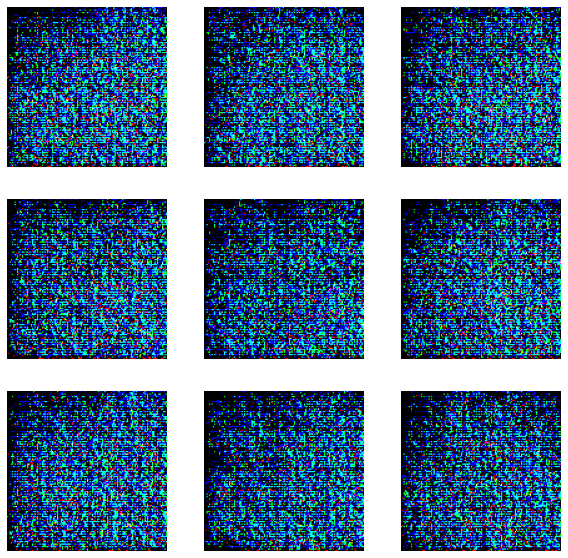

  501/37469 [..............................] - ETA: 1:15:55 - critic_loss: -0.0032 - generator_loss: -0.0068 - info_loss: 1.0088 - gradient_penalty_loss: 0.9846

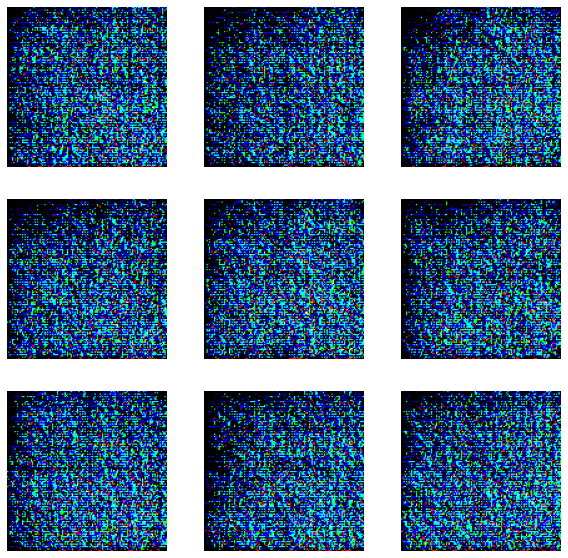

  839/37469 [..............................] - ETA: 1:16:20 - critic_loss: -0.0032 - generator_loss: -0.0068 - info_loss: 1.0043 - gradient_penalty_loss: 0.9845

KeyboardInterrupt: 

In [5]:
gan_cp_file = f'{home}/session/infoWGAN_cp.h5'
training = True
if os.path.exists(gan_cp_file):
    print("found checkpoint, loading")
    load = True
else:
    load = False
if load and not training:
    gan_trainer = tf.keras.models.load_model(gan_cp_file)
else:
    gan_trainer = InfoWGAN(code_features, noise_features, pixel_features, decoder_filters_list)
    
if training:
#     d_opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0, beta_2=0.9, epsilon=1e-05, name='Adam')
#     g_opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0, beta_2=0.9, epsilon=1e-05, name='Adam')
#     q_opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9, epsilon=1e-05, name='Adam')
    d_opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001,name='RMSprop')
    g_opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001,name='RMSprop')
    q_opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001,name='RMSprop')
    gan_trainer.compile(d_opt, g_opt, q_opt, gradLAMBDA, infoLAMBDA)
    if load:
        print("loading model weights for training")
        gan_trainer.load_weights(filepath=gan_cp_file)
    
    gan_trainer.generator.summary()
    gan_trainer.coder.summary()
    gan_trainer.criticHead.summary()
    gan_trainer.coderHead.summary()
    gan_trainer.fit(train_dataset, epochs=3, validation_data=val_dataset, validation_steps=5, validation_freq=1,
                workers=3, callbacks=[
#                                      tf.keras.callbacks.ModelCheckpoint(gan_cp_file, verbose=1, save_freq=500),
                                     ShowGeneratorCallback(display=500),
                                     MemoryCallback()])
